# Elastodynamics - Implicit integrator

Weak formulation of elastodynamic medium in specific time instant $t_{i+1}$ reads: Find $\mathbf{u}_{i+1}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}_{i+1}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + 
\int_\Omega\rho\ddot{\mathbf{u}}_{i+1}\cdot\delta\mathbf{u}\,\mathrm{d}\Omega +
\int_{\partial\Omega}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u},
\end{equation}
where again
\begin{equation}
\boldsymbol{\sigma}=\lambda\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}, \boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\mathbf{u}+\nabla^{\mathrm{T}}\mathbf{u}\right), \delta\boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\delta\mathbf{u}+\nabla^{\mathrm{T}}\delta\mathbf{u}\right).
\end{equation}

Time integration scheme depends on discretization of second derivative. For constant acceleration Newmark method speed and displacement in time $t_{i+1}$ can be evaluated based on values in time $t_i$ as
\begin{equation}
\dot{\mathbf{u}}_{i+1}=\dot{\mathbf{u}}_{i} + \frac{\Delta t}{2}(\ddot{\mathbf{u}}_{i} + \ddot{\mathbf{u}}_{i+1}),
\end{equation}
\begin{equation}
\mathbf{u}_{i+1} = \mathbf{u}_{i} + \Delta t\dot{\mathbf{u}}_{i} + \frac{\Delta t^2}{4}(\ddot{\mathbf{u}}_{i} + \ddot{\mathbf{u}}_{i+1}),
\end{equation}
which can be rearranged to
\begin{equation}
\ddot{\mathbf{u}}_{i+1} = \frac{4}{\Delta t^2}(\mathbf{u}_{i+1} - \tilde{\mathbf{u}}_{i}),
\end{equation}
where auxiliary variable
\begin{equation}
\tilde{\mathbf{u}}_{i} = \mathbf{u}_{i} + \Delta t\dot{\mathbf{u}}_{i} + \frac{\Delta t^2}{4}\ddot{\mathbf{u}}_{i}
\end{equation}
depends only on old values. After substituting to previous weak form, we get final relationship for $\mathbf{u}_{i+1}$ calculation:

Find $\mathbf{u}_{i+1}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}_{i+1}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + 
\int_\Omega\rho\left(\frac{4}{\Delta t^2}(\mathbf{u}_{i+1} - \tilde{\mathbf{u}}_{i})\right)\cdot\delta\mathbf{u}\,\mathrm{d}\Omega +
\int_{\partial\Omega}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u},
\end{equation}

## Implementation

We again import all neccessary packages and define auxiliary functions and parameters. 

In [10]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import time


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


def indent_area(x, on_boundary):
    return (on_boundary and fe.near(x[1], l_y) and abs(x[0] - 0.5*l_x) < 0.2*l_x)


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1.0
rho = 1.0

l_x, l_y, l_z = 1.0, 1.0, 0.1  # Domain dimensions
n_x, n_y, n_z = 100, 100, 2  # Number of elements

# Load
f_int = 1.0e-1

And we also define start time, end time and time step. There is many options how define time loop, it is possible for example via `linspace()` which create equidistantly distributed array of numbers. 

In [11]:
# Time-stepping
t_start = 0.0  # start time
t_end = 1.0  # end time
t_steps = 40  # number of time steps

t = np.linspace(t_start, t_end, t_steps)
dt = np.asscalar(t[1] - t[0])

Mesh is created using predefined object `BoxMesh`.

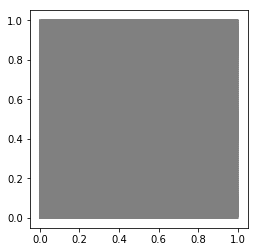

In [12]:
# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

fe.plot(mesh)
plt.show()

As earlier we create vector-value function space and appropriate trial and test function.

In [13]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 2)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

Neumann boundary conditions are prescribed as previously. For moving Dirichlet boundary condition we can also in each time step define new `DirichletBC` object and send it to solver. There is more elegant way using FEniCS object `Expression`. 
> TODO: More about expressions / creating user defined expression

In [14]:
# --------------------
# Boundary conditions
# --------------------
u_D = fe.Expression("-t/100", t=0.0, degree=0)

bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(V.sub(1), u_D, indent_area)
bc = [bc1, bc2]

Now we can create all functions we need, where `u_bar` represents $\tilde{\mathbf{u}}$, `du` is $\dot{\mathbf{u}}$ and `ddu` is $\ddot{\mathbf{u}}$. Since we create object `Function`... 

In [15]:
# --------------------
# Initialization
# --------------------
u = fe.Function(V)
u_bar = fe.Function(V)
du = fe.Function(V)
ddu = fe.Function(V)
ddu_old = fe.Function(V)

We need also identify output file. In dynamic regime it is valuabe works with `.xdmf` files. Creation is perfomed by

In [16]:
file = fe.XDMFFile("FEniCS_2a_output.xdmf")  # XDMF file

Finally, we can write down the weak form of our problem. We define this form outside of time loop. It is possible by using object `Function`. For example if we use `u_tr` in formulation, FEniCS remember the pointer on this object. We cannot redefine `u_tr` by classic way `u_tr=...`, but we must use methods of `Function` for redefining, shown later.

In [17]:
# --------------------
# Weak form
# --------------------
A_form = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx + 4*rho/(dt*dt)*fe.dot(u_tr - u_bar, u_test)*fe.dx

Time loop is simple `for` cycle where the first line is redefinition of `u_bar` for given time step. Next part is classical solver and the rest is updating of auxiliary variables `ddu_old`, `ddu` and `du`. Line `file.write(u, ti)` write displacement solution, where second argument is given time.
> TODO: Okomentovat funkci assign

In [18]:
# --------------------
# Time loop
# --------------------
for ti in t:
    u_D.t = ti
    u_bar.assign(u + dt*du + 0.25*dt*dt*ddu)
    
    #A, b = fe.assemble_system(fe.lhs(A_form), fe.rhs(A_form), bc)
    #fe.solve(A, u.vector(), b, "cg", "jacobi")
    fe.solve(fe.lhs(A_form) == fe.rhs(A_form), u, bc)
    
    ddu_old.assign(ddu)
    ddu.assign(4/(dt*dt)*(u - u_bar))
    du.assign(du + 0.5*dt*(ddu + ddu_old))

    file.write(u, ti)
    
    print(ti)
file.close()

0.0
0.025641025641
0.0512820512821
0.0769230769231
0.102564102564
0.128205128205
0.153846153846
0.179487179487
0.205128205128
0.230769230769
0.25641025641
0.282051282051
0.307692307692
0.333333333333
0.358974358974
0.384615384615
0.410256410256
0.435897435897
0.461538461538
0.487179487179
0.512820512821
0.538461538462
0.564102564103
0.589743589744
0.615384615385
0.641025641026
0.666666666667
0.692307692308
0.717948717949
0.74358974359
0.769230769231
0.794871794872
0.820512820513
0.846153846154
0.871794871795
0.897435897436
0.923076923077
0.948717948718
0.974358974359
1.0


In [7]:
# --------------------
# Boundary conditions
# --------------------
u_D = fe.Expression("t", t=0.0)

bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(V.sub(1), u_D, indent_area)

# --------------------
# Initialization
# --------------------
u = fe.Function(V)
u_bar = fe.Function(V)
du = fe.Function(V)
ddu = fe.Function(V)
ddu_old = fe.Function(V)

file = fe.XDMFFile("FEniCS_2a_output.xdmf")  # XDMF file
f = fe.Constant((0.0, 0.0, f_int))  # Surface traction
t = np.linspace(t_start, t_end, t_steps)
dt = np.asscalar(t[1] - t[0])

# --------------------
# Weak form
# --------------------
A_form = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx + 4*rho/(dt*dt)*fe.dot(u_tr - u_bar, u_test)*fe.dx - fe.inner(f, u_test)*ds(1)

start = time.time()
# --------------------
# Time loop
# --------------------
for ti in t:
    u_bar.assign(u + dt*du + 0.25*dt*dt*ddu)
    
    A, b = fe.assemble_system(fe.lhs(A_form), fe.rhs(A_form), bc)
    fe.solve(A, u.vector(), b, "cg", "jacobi")
    #fe.solve(fe.lhs(A_form) == fe.rhs(A_form), u, bc)
    
    ddu_old.assign(ddu)
    ddu.assign(4/(dt*dt)*(u - u_bar))
    du.assign(du + 0.5*dt*(ddu + ddu_old))

    file.write(u, ti)
    
    print(ti)

end = time.time()
print(end - start)
# --------------------
# Post-process
# --------------------
file.close()

0.0
2.5641025641
5.12820512821
7.69230769231
10.2564102564
12.8205128205
15.3846153846
17.9487179487
20.5128205128
23.0769230769
25.641025641
28.2051282051
30.7692307692
33.3333333333
35.8974358974
38.4615384615
41.0256410256
43.5897435897
46.1538461538
48.7179487179
51.2820512821
53.8461538462
56.4102564103
58.9743589744
61.5384615385
64.1025641026
66.6666666667
69.2307692308
71.7948717949
74.358974359
76.9230769231
79.4871794872
82.0512820513
84.6153846154
87.1794871795
89.7435897436
92.3076923077
94.8717948718
97.4358974359
100.0
76.44880890846252
